# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import seaborn as sns

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

In [2]:
# biplot for task 7
def colored_label_plot(ax, x, y, color, label):
    ax.set_ylabel(label, color=color)
    ax.plot(x, y, color=color, label=label)
    ax.tick_params(axis='y', labelcolor=color)

def biplot(x, y1, y2, labels, colors):
    fig, ax = plt.subplots()
    ax.set_xlabel(labels[0])
    colored_label_plot(ax, x, y1, colors[0], labels[1])
    ax2 = ax.twinx()
    ax2.grid(False)
    colored_label_plot(ax2, x, y2, colors[1], labels[2])
    plt.show()

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [3]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) < 1:
        return 0
    return np.var(y)

In [4]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [5]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """
    mask = X[:, j] < t
    R_l = y[mask]
    R_r = y[~mask]

    Q_val = (H(R_l) * R_l.size + H(R_r) * R_r.size) / X.shape[0]

    return Q_val

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [6]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self, depth = None):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = depth
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [7]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        
        objects, features = X.shape

        for feature in range(features):
            thresholds = X[:, feature]
            for threshold in thresholds:
                cost = Q(X, y, feature, threshold)
                if cost < best_cost:
                    best_cost = cost
                    best_split_column = feature
                    best_threshold = threshold

        if best_split_column == None:
            return tuple([None] * 6)

        mask = X[:, best_split_column] < best_threshold
        X_left = X[mask, :]
        X_right = X[~mask, :]
        y_left = y[mask]
        y_right = y[~mask]
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        if len(y) < self.min_samples_leaf:
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal = True
            return

        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        if best_split_column == None:
            node.is_terminal = True
            return

        node.column = best_split_column
        node.threshold = best_threshold

        node.left = Node(node.depth + 1)
        node.right = Node(node.depth + 1)

        node.left.prediction = np.mean(y_left)
        node.right.prediction = np.mean(y_right)

        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        if y is None:
            raise ValueError('requires y to be passed, but the target y is None')
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True

        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 1                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction

        if x[node.column] < node.threshold:
            y_pred = self.get_prediction(node.left, x)
        else:
            y_pred = self.get_prediction(node.right, x)
        
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [8]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, export_text, export_graphviz

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
X, y = data, target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

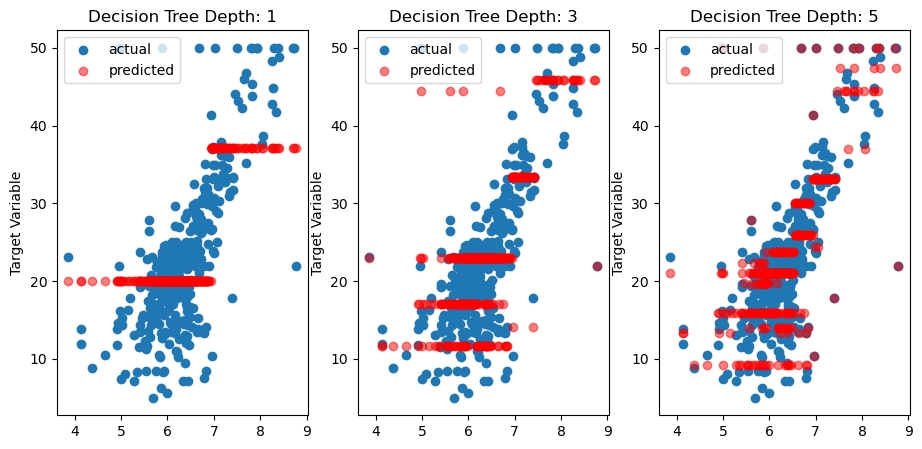

Overfitting for each depth: [False, True, True]


In [12]:
import graphviz

depths = [1, 3, 5]
trees = []
for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train, y_train)
    trees.append(tree)

for i, tree in enumerate(trees, 1):
    plt.subplot(1, 3, i)
    plt.scatter(X_train[:, 5], y_train, label='actual')
    plt.scatter(X_train[:, 5], tree.predict(X_train), label='predicted', color='r', alpha=0.5)
    plt.ylabel('Target Variable')
    plt.title(f'Decision Tree Depth: {depths[i-1]}')
    plt.legend()
plt.show()

mae_train = []
mae_test = []
for tree in trees:
    mae_train.append(mean_absolute_error(y_train, tree.predict(X_train)))
    mae_test.append(mean_absolute_error(y_test, tree.predict(X_test)))

overfitting = [mae_train[i] < mae_test[i] for i in range(len(depths))]
print("Overfitting for each depth:", overfitting)

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [1, 2, 3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

gs = GridSearchCV(MyDecisionTreeRegressor(), params, scoring='neg_root_mean_squared_error', cv=5)
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 7, 'min_samples_leaf': 10}

In [14]:
best_model = gs.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print(f"Best Hyperparameters: {gs.best_params_}")
print(f"MAE on Test Set: {mae}")

Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 10}
MAE on Test Set: 2.495534595371935


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right]
$$
$$
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [15]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        n, m = x.shape

        predicts = np.full((n, n_iter), np.nan)

        for i in range(n_iter):
            rand_index = np.random.choice(n, n)
            tmp = np.full(n, True)
            tmp[rand_index] = False
            estimator.fit(x[rand_index, :], y[rand_index])
            predict = estimator.predict(x[tmp, :])
            predicts[tmp, i] = predict

        bias = np.nanmean((np.nanmean(predicts, axis=1) - y_train)**2)
        variance = np.nanmean(np.nanvar(predicts, axis=1))

    return bias, variance

In [16]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

(21.30705721380842, 8.721451900239813)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

In [17]:
min_samples_splits = range(1, 100, 10)

data = np.array([
    get_bias_variance(MyDecisionTreeRegressor(min_samples_split=i), X_train, y_train, 10) for i in min_samples_splits
])

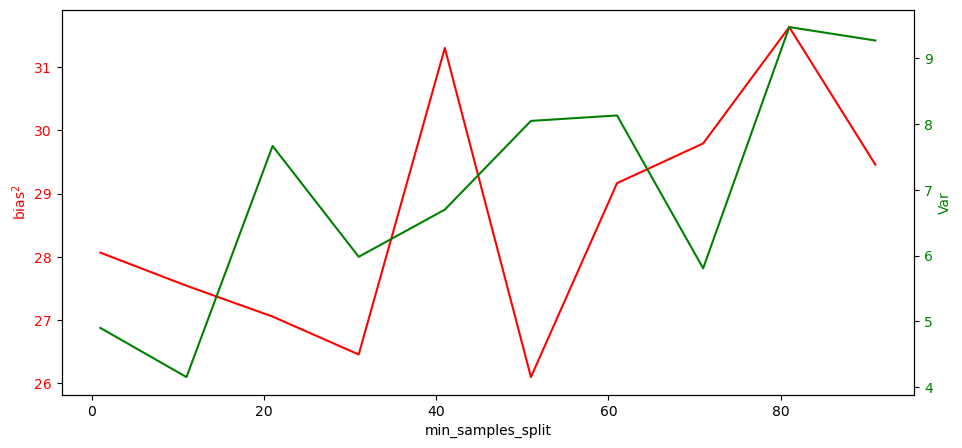

In [18]:
biplot(min_samples_splits, data[:,0], data[:,1], ["min_samples_split", "bias$^2$", "Var"], ['red', 'green'])

Larger values of `min_samples_split` result in simpler trees with fewer splits. This tends to increase bias and reduce variance.

Smaller values of `min_samples_split` lead to more complex trees with more splits. This can decrease bias but may increase variance.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [19]:
from sklearn.ensemble import BaggingRegressor

breg = BaggingRegressor(estimator, random_state=412)
get_bias_variance(breg, X_train, y_train, 10)

(16.227448372099403, 1.6710733794490331)

* In theory bagging is unlikely to have a significant impact on bias. The main purpose of bagging is to reduce variance. By training on different subsets of the data, each model will make different errors. When combined, these errors tend to cancel each other out, leading to a more stable and less variable overall prediction.

* Generally, the bias of the bagged ensemble should be similar to the bias of an individual tree (almost in my case, I would say), as bagging is not designed to impact bias. But we can see that the variance is conciderably lower!

* Results are aligning with the theory, as we can observe a reduction of the variance value.

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task. 

In [6]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')
df

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,6.705989e+07,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,2540,1000,Healthcare,Yu Rong,51.0,China,Shanghai,Health clinics,Healthcare,China,...,2.9,"$19,910,000,000,000",50.6,100.2,77.0,9.4,59.2,1.397715e+09,35.861660,104.195397
2636,2540,1000,Food & Beverage,"Richard Yuengling, Jr.",80.0,United States,Pottsville,Beer,Food & Beverage,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
2637,2540,1000,Manufacturing,Zhang Gongyun,60.0,China,Gaomi,Tyre manufacturing machinery,Manufacturing,China,...,2.9,"$19,910,000,000,000",50.6,100.2,77.0,9.4,59.2,1.397715e+09,35.861660,104.195397
2638,2540,1000,Real Estate,Zhang Guiping & family,71.0,China,Nanjing,Real estate,Real Estate,China,...,2.9,"$19,910,000,000,000",50.6,100.2,77.0,9.4,59.2,1.397715e+09,35.861660,104.195397


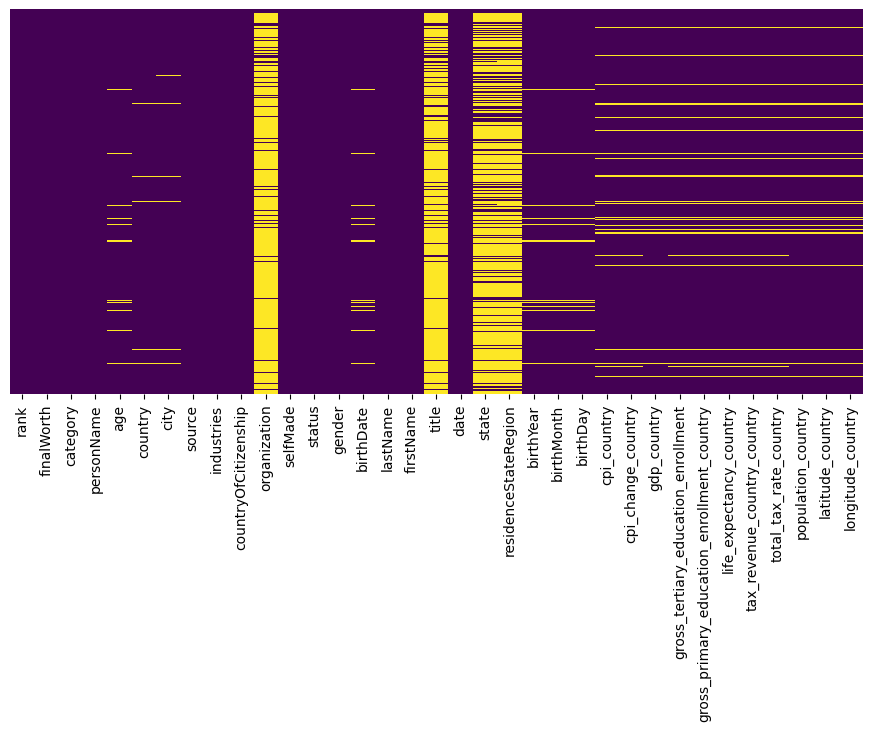

In [7]:
fig, ax = plt.subplots()
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

**missing values**

In [8]:
df.describe(include=['O'])

,category,personName,country,city,source,industries,countryOfCitizenship,organization,status,gender,birthDate,lastName,firstName,title,date,state,residenceStateRegion,gdp_country
count,2640,2640,2602,2568,2640,2640,2640,325,2640,2640,2564,2640,2637,339,2640,753,747,2476
unique,18,2638,78,741,906,18,77,294,6,2,2060,1736,1770,97,2,45,5,68
top,Finance & Investments,Wang Yanqing & family,United States,New York,Real estate,Finance & Investments,United States,Meta Platforms,D,M,1/1/1965 0:00,Li,John,Investor,4/4/2023 5:01,California,West,"$21,427,700,000,000"
freq,372,2,754,99,151,372,735,4,1223,2303,19,44,40,44,2638,178,248,754


In [9]:
df.describe()

,rank,finalWorth,age,birthYear,birthMonth,birthDay,cpi_country,cpi_change_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
count,2640.000000,2640.000000,2575.000000,2564.000000,2564.000000,2564.000000,2456.000000,2456.000000,2458.000000,2459.000000,2458.000000,2457.000000,2458.000000,2.476000e+03,2476.000000,2476.000000
mean,1289.159091,4623.787879,65.140194,1957.183307,5.740250,12.099844,127.755204,4.364169,67.225671,102.858520,78.122823,12.546235,43.963344,5.102053e+08,34.903592,12.583156
std,739.693726,9834.240939,13.258098,13.282516,3.710085,9.918876,26.452951,3.623763,21.343426,4.710977,3.730099,5.368625,12.145296,5.542447e+08,17.003497,86.762989
min,1.000000,1000.000000,18.000000,1921.000000,1.000000,1.000000,99.550000,-1.900000,4.000000,84.700000,54.300000,0.100000,9.900000,3.801900e+04,-40.900557,-106.346771
25%,659.000000,1500.000000,56.000000,1948.000000,2.000000,1.000000,117.240000,1.700000,50.600000,100.200000,77.000000,9.600000,36.600000,6.683440e+07,35.861660,-95.712891
50%,1312.000000,2300.000000,65.000000,1957.000000,6.000000,11.000000,117.240000,2.900000,65.600000,101.800000,78.500000,9.600000,41.200000,3.282395e+08,37.090240,10.451526
75%,1905.000000,4200.000000,75.000000,1966.000000,9.000000,21.000000,125.080000,7.500000,88.200000,102.600000,80.900000,12.800000,59.100000,1.366418e+09,40.463667,104.195397
max,2540.000000,211000.000000,101.000000,2004.000000,12.000000,31.000000,288.570000,53.500000,136.600000,142.100000,84.200000,37.200000,106.300000,1.397715e+09,61.924110,174.885971


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

threshold = 0.3 * len(df)
df = df.dropna(thresh=threshold, axis=1)
df = df.drop(['rank', 'personName', 'birthYear', 'birthMonth',
              'birthDay', 'birthDate', 'date', 'lastName', 'firstName',
              'city', 'source', 'industries',], axis=1)
df.isna().sum()

finalWorth                                      0
category                                        0
age                                            65
country                                        38
countryOfCitizenship                            0
selfMade                                        0
status                                          0
gender                                          0
cpi_country                                   184
cpi_change_country                            184
gdp_country                                   164
gross_tertiary_education_enrollment           182
gross_primary_education_enrollment_country    181
life_expectancy_country                       182
tax_revenue_country_country                   183
total_tax_rate_country                        182
population_country                            164
latitude_country                              164
longitude_country                             164
dtype: int64

So we dropped columns with more then 30% missing value which would be hard to deal with.

As well as some irrelevant info (different dates and names, not including `age`).

In [11]:
df.describe()

,finalWorth,age,cpi_country,cpi_change_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
count,2640.000000,2575.000000,2456.000000,2456.000000,2458.000000,2459.000000,2458.000000,2457.000000,2458.000000,2.476000e+03,2476.000000,2476.000000
mean,4623.787879,65.140194,127.755204,4.364169,67.225671,102.858520,78.122823,12.546235,43.963344,5.102053e+08,34.903592,12.583156
std,9834.240939,13.258098,26.452951,3.623763,21.343426,4.710977,3.730099,5.368625,12.145296,5.542447e+08,17.003497,86.762989
min,1000.000000,18.000000,99.550000,-1.900000,4.000000,84.700000,54.300000,0.100000,9.900000,3.801900e+04,-40.900557,-106.346771
25%,1500.000000,56.000000,117.240000,1.700000,50.600000,100.200000,77.000000,9.600000,36.600000,6.683440e+07,35.861660,-95.712891
50%,2300.000000,65.000000,117.240000,2.900000,65.600000,101.800000,78.500000,9.600000,41.200000,3.282395e+08,37.090240,10.451526
75%,4200.000000,75.000000,125.080000,7.500000,88.200000,102.600000,80.900000,12.800000,59.100000,1.366418e+09,40.463667,104.195397
max,211000.000000,101.000000,288.570000,53.500000,136.600000,142.100000,84.200000,37.200000,106.300000,1.397715e+09,61.924110,174.885971


In [12]:
df.describe(include=['O'])

,category,country,countryOfCitizenship,status,gender,gdp_country
count,2640,2602,2640,2640,2640,2476
unique,18,78,77,6,2,68
top,Finance & Investments,United States,United States,D,M,"$21,427,700,000,000"
freq,372,754,735,1223,2303,754


In [13]:
le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ],
    remainder='passthrough'
)

# Transform the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [15]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score, roc_curve

In [16]:
models = [
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("SVM", SVC()),
    ("Logistic Regression", LogisticRegression())
]

# Choose cross-validation strategy (Stratified K-Fold for handling class imbalance)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    print(f"{name}: F1 Score - Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")
    m = model.fit(X_train, y_train)
    test_pred = m.predict(X_test)
    train_pred = m.predict(X_train)
    test_score = f1_score(y_test, test_pred)
    train_score = f1_score(y_train, train_pred)
    print(f"{name} overfitting: ({train_score:.3f} > {test_score:.3f})")


Gradient Boosting: F1 Score - Mean: 0.8590, Std: 0.0113
Gradient Boosting overfitting: (0.894 > 0.868)
Random Forest: F1 Score - Mean: 0.8460, Std: 0.0060
Random Forest overfitting: (1.000 > 0.859)
Decision Tree: F1 Score - Mean: 0.8134, Std: 0.0116
Decision Tree overfitting: (1.000 > 0.817)
SVM: F1 Score - Mean: 0.8161, Std: 0.0000
SVM overfitting: (0.816 > 0.808)
Logistic Regression: F1 Score - Mean: 0.8161, Std: 0.0000
Logistic Regression overfitting: (0.816 > 0.808)


Considering scores it's pretty much safe to say that all models **do overfit**. (especially tree-based models)

However, `SVM` and `Logit` are overfitting the least. Which makes them (looking at GB scoring) the best out of these five.

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [4, 6, 8]
}

catboost_model = CatBoostClassifier()

gs = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=5, scoring='f1')
gs.fit(X_train, y_train)

best_params = gs.best_params_
best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

test_pred = best_model.predict(X_test)
train_pred = best_model.predict(X_train)
test_score = f1_score(y_test, test_pred)
train_score = f1_score(y_train, train_pred)

In [21]:
print(f"CatBoost overfitting: ({train_score:.3f} > {test_score:.3f})")
print("Best hyperparameters:", best_params)
print("F1 score:", f1_score(y_test, test_pred))

CatBoost overfitting: (0.896 > 0.870)
Best hyperparameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}
F1 score: 0.869653767820774


In [22]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.84      0.49      0.62       213
           1       0.80      0.96      0.87       447

    accuracy                           0.81       660
   macro avg       0.82      0.72      0.75       660
weighted avg       0.81      0.81      0.79       660



A higher F1 score indicates better overall performance in terms of balancing precision and recall, which it is in CatBoost model (slightly overfitted however).

And still loses to `SVM` and `Logit` in our specific case

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [27]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier

clf1 = DecisionTreeClassifier(max_depth=3)
clf2 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
clf3 = LogisticRegression()

models = [
    ("Bagging with decision trees",
     BaggingClassifier(DecisionTreeClassifier())),
    ("Bagging with gradient boosting",
     BaggingClassifier(GradientBoostingClassifier(n_estimators=110))),
    ("Voting classifier",
     VotingClassifier(estimators=[('dt', clf1), ('gb', clf2), ('lr', clf3)], voting='soft')),
    ("Stacking Classifier with Logistic Regression",
     StackingClassifier(estimators=[('dt', clf1), ('gb', clf2)], final_estimator=clf3)),
    ("Stacking Classifier with Gradeint Boosting",
     StackingClassifier(estimators=[('dt', clf1), ('gb', clf2)], final_estimator=clf2)),
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    print(f"{name}: F1 Score - Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")
    m = model.fit(X_train, y_train)
    test_pred = m.predict(X_test)
    train_pred = m.predict(X_train)
    test_score = f1_score(y_test, test_pred)
    train_score = f1_score(y_train, train_pred)
    print(f"{name} overfitting: {train_score:.3f} > {test_score:.3f}\n")

Bagging with decision trees: F1 Score - Mean: 0.8274, Std: 0.0134
Bagging with decision trees overfitting: 0.992 > 0.845

Bagging with gradient boosting: F1 Score - Mean: 0.8631, Std: 0.0109
Bagging with gradient boosting overfitting: 0.895 > 0.863

Voting classifier: F1 Score - Mean: 0.8560, Std: 0.0141
Voting classifier overfitting: 0.864 > 0.841

Stacking Classifier with Logistic Regression: F1 Score - Mean: 0.8613, Std: 0.0131
Stacking Classifier with Logistic Regression overfitting: 0.886 > 0.863

Stacking Classifier with Gradeint Boosting: F1 Score - Mean: 0.8616, Std: 0.0110
Stacking Classifier with Gradeint Boosting overfitting: 0.881 > 0.853



* `Stacking Classifier with Logistic Regression` has the best perfomance, which makes sense considering results of [Task 2](#task2_2).

* Bagging can provide an additional regularization effect that may help reduce overfitting. (provides a more robust model)

* The difference is in how they combine the predictions of individual models:
    * **Voting Classifier** combines the predictions of multiple base models by a majority vote (for classification) or averaging (for regression).
    * **Stacking Classifier** trains a meta-model (blender) to make predictions based on the outputs of multiple base models. Stacking allows the blender to learn the optimal way to combine the predictions of the base models.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [30]:
# Stacking with Logit
best_model = StackingClassifier(estimators=[('dt', clf1), ('gb', clf2)], final_estimator=clf3)
best_model.fit(X_train, y_train)

test_pred = best_model.predict(X_test)
train_pred = best_model.predict(X_train)
test_score = f1_score(y_test, test_pred)
train_score = f1_score(y_train, train_pred)

print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.85      0.44      0.58       213
           1       0.78      0.96      0.86       447

    accuracy                           0.79       660
   macro avg       0.81      0.70      0.72       660
weighted avg       0.80      0.79      0.77       660

